In [8]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [26]:
"""生成数据"""
def synthetic_data(w, b, num_examples):
    """w=[2, -3.4], b=4.2和噪声生成数据集和标签"""
    X = torch.normal(0, 1, (num_examples, len(w)))
        # torch.normal()是从正态分布中随机抽取数值
        # 以0为平均值
        # 以1为标准差
        # (num_example行 * len(w)列)
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)     # 对y添加了正态分布随机噪声
    return X, y.reshape((-1, 1))    # 将y重塑成一个二维张量，-1表示行数自动，1表示一列

In [10]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)  # 用上面定义的synthetic_data()生成数据

In [11]:
for i in range(10):
    print('features:', features[i], ' labels:', labels[i])

features: tensor([1.0726, 1.2729])  labels: tensor([2.0162])
features: tensor([-1.3425, -1.6261])  labels: tensor([7.0586])
features: tensor([ 4.1174, -0.5270])  labels: tensor([14.2064])
features: tensor([-1.3966,  0.5923])  labels: tensor([-0.6048])
features: tensor([ 0.5175, -0.1640])  labels: tensor([5.8094])
features: tensor([-0.5801, -0.2796])  labels: tensor([3.9888])
features: tensor([-0.4567,  0.7279])  labels: tensor([0.8104])
features: tensor([0.6125, 0.2349])  labels: tensor([4.6332])
features: tensor([0.5794, 0.1104])  labels: tensor([4.9942])
features: tensor([-0.0765, -0.0453])  labels: tensor([4.2167])


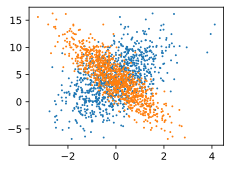

In [12]:
"""可视化两个特征和y的线性关系"""
d2l.set_figsize()
d2l.plt.scatter(features[:, 0].detach().numpy(), labels.detach().numpy(), 1)    # 标签和第一个特征的关系
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)    # 标签和第二个特征的关系

In [13]:
"""读取数据集"""
def data_iter(batch_size, features, labels):
    num_example = len(features)
    indices = list(range(num_example))  
    random.shuffle(indices)     # 打乱索引
    for i in range(0, num_example, batch_size):  # 生成若干组批，每个批量包含一组特征和标签
        # range从0起，每次增长步长为batch_size。如0\b\2b
        # 对indices切片长度为batch_size，即每次切nb~(n+1)b的索引
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_example)])
        # 每次返回一批features和label
        yield features[batch_indices], labels[batch_indices]

In [14]:
"""展示一批X和y"""
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.9325, -0.4164],
        [ 0.0042, -0.3810],
        [-0.9615,  0.6943],
        [ 0.1927,  1.3134],
        [ 0.6962, -0.7763],
        [ 0.1894,  0.3876],
        [-1.5160,  0.2064],
        [-0.0263, -0.7479],
        [ 0.5892,  0.7367],
        [-0.8224,  0.3476]]) 
 tensor([[ 7.4809],
        [ 5.4941],
        [-0.0761],
        [ 0.1131],
        [ 8.2217],
        [ 3.2625],
        [ 0.4841],
        [ 6.7003],
        [ 2.8739],
        [ 1.3717]])


In [15]:
"""定义包含一个线性层Linear的网络net"""
from torch import nn
net = nn.Sequential(nn.Linear(2, 1))
# .Sequential()作用：用来创建序列化容器，即按照参数(层)的顺序，创建网络
    # 比如：
    # model = nn.Sequential(
    # nn.Linear(in_features, hidden_features),  # 第一个线性层
    # nn.ReLU(),                                # ReLU激活层
    # nn.Linear(hidden_features, out_features)  # 第二个线性层
    # )
    # 创建了一个有三层的网络
# .linear()作用过程即：X(M*N) * W(N*P) = Y(M*P)
    # nn.linear()创建一个线性层(也称全连接、密集层)
    # 第一个参数in_features (int)表示输入特征数量
    # 第二个参数out_features (int)，表示输出特征的数量
    # 参数bias默认为True表示有bias
net[0].weight.data.normal_(0, 0.01)
    # 权重矩阵weight形状为(out_features*in_features)，以(0, 0.01)正态分布填充
net[0].bias.data.fill_(0) 
    # 初始偏置值均为0

tensor([0.])

In [16]:
"""定义损失函数MSELoss"""
loss = nn.MSELoss()  #均方误差

In [17]:
"""定义优化器"""
trainer = torch.optim.SGD(net.parameters(), lr=0.03)    # 用梯度下降优化

In [25]:
"""训练模型"""
num_epochs = 3
for epochs in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):   # data_iter是小批的迭代器
        l = loss(net(X), y)  # 1.算损失
        # net是网络，net(X)是这个网络对于输入X完整的前向输出(对于这个线性模型，就是预测的y)
        # loss()计算损失函数：算模型net在输入X时，对目标值y的误差
            # l就是(net(X)对y)的损失
            # data_iter是小批的迭代器，每个X和y是每小批特征和目标值
        trainer.zero_grad()  # 每次迭代中计算新的梯度前，需要清除旧的梯度
        l.backward() # 2.算梯度
        """
        反向传播的任务是计算这个损失值相对于网络参数,如权重和偏差的梯度
        一旦梯度被计算出来，它们会被存储在相应参数的.grad 属性中,
        例如:如果模型有一个名为weight的参数,则在执行l.backward()后,weight.grad将包含l相对于weight的梯度。
        l.backward()是反向传播的一部分, backward()会计算损失函数l关于模型参数的梯度,这些梯度随后用于更新模型参数。
        """
        trainer.step()  # 3.基于刚才算得的梯度，更新weight
    l = loss(net(features), labels)  # 当前epoch所有批遍历完，输出当前epoch的损失
    print(f'epoch{epochs+1}, loss{l:f}')

epoch1, loss0.000108
epoch2, loss0.000108
epoch3, loss0.000108


In [20]:
w = net[0].weight.data
b = net[0].bias.data
print(f'true_w:{true_w}, pre_w:{w}')
print(f'true_b:{true_b}, pre_b:{b}')

true_w:tensor([ 2.0000, -3.4000]), pre_w:tensor([[ 2.0005, -3.4008]])
true_b:4.2, pre_b:tensor([4.2003])
